## 1. Import Required Libraries

In [21]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Sector Stocks Data

In [22]:
# Load the sector stocks CSV
sector_df = pd.read_csv('sector_stocks.csv')

print(f"Total stocks loaded: {len(sector_df)}")
print(f"\nStocks by sector:")
print(sector_df['Sector_Code'].value_counts().sort_index())
print(f"\nFirst few rows:")
sector_df.head(10)

Total stocks loaded: 307

Stocks by sector:
Sector_Code
XLF    66
XLI    66
XLK    62
XLV    64
XLY    49
Name: count, dtype: int64

First few rows:


,Symbol,Sector,Sector_Code
0,AAPL,Technology,XLK
1,MSFT,Technology,XLK
2,NVDA,Technology,XLK
3,AVGO,Technology,XLK
4,CRM,Technology,XLK
5,ORCL,Technology,XLK
6,CSCO,Technology,XLK
7,ACN,Technology,XLK
8,AMD,Technology,XLK
9,ADBE,Technology,XLK


## 3. Data Overview and Summary Statistics

In [23]:
# Display basic information
print("Dataset Shape:", sector_df.shape)
print("\nColumn Names:")
print(sector_df.columns.tolist())
print("\nData Types:")
print(sector_df.dtypes)
print("\nMissing Values:")
print(sector_df.isnull().sum())
print("\nUnique Sectors:")
print(sector_df['Sector'].unique())

Dataset Shape: (307, 3)

Column Names:
['Symbol', 'Sector', 'Sector_Code']

Data Types:
Symbol         object
Sector         object
Sector_Code    object
dtype: object

Missing Values:
Symbol         0
Sector         0
Sector_Code    0
dtype: int64

Unique Sectors:
['Technology' 'Healthcare' 'Financial' 'Industrial'
 'Consumer Discretionary']


## 4. Visualize Sector Distribution

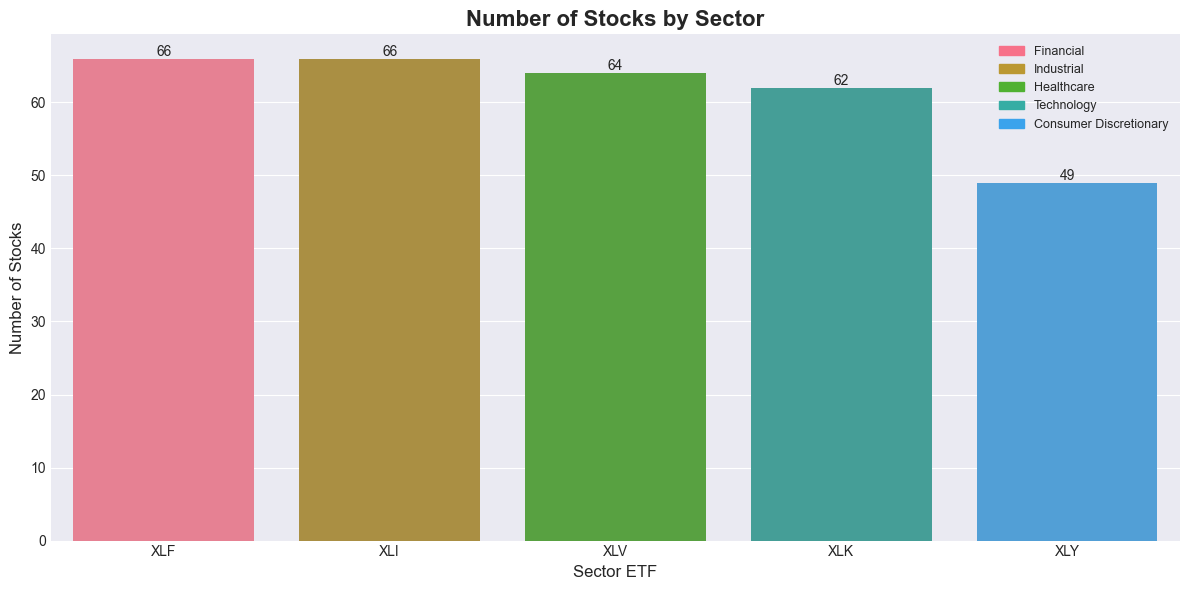


Sector Distribution:
  Sector_Code                  Sector  Count
0         XLF               Financial     66
1         XLI              Industrial     66
3         XLV              Healthcare     64
2         XLK              Technology     62
4         XLY  Consumer Discretionary     49


In [24]:
# Create a bar plot of stocks per sector
plt.figure(figsize=(12, 6))
sector_counts = sector_df.groupby(['Sector_Code', 'Sector']).size().reset_index(name='Count')
sector_counts = sector_counts.sort_values('Count', ascending=False)

ax = sns.barplot(data=sector_counts, x='Sector_Code', y='Count', hue='Sector', dodge=False, legend=False)
plt.title('Number of Stocks by Sector', fontsize=16, fontweight='bold')
plt.xlabel('Sector ETF', fontsize=12)
plt.ylabel('Number of Stocks', fontsize=12)

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fontsize=10)

# Add legend with full sector names
handles = [plt.Rectangle((0,0),1,1, color=sns.color_palette('husl')[i]) for i in range(len(sector_counts))]
plt.legend(handles, sector_counts['Sector'].tolist(), loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

print("\nSector Distribution:")
print(sector_counts)

## 5. Select Stocks for Analysis
Choose whether to analyze all stocks or just top 3 from each sector.

**Note**: The following 5 stocks failed to download from Yahoo Finance and hence were  excluded from analysis:
- DFS (Financial)
- JNPR (Technology)
- TPX (Consumer Discretionary)
- ANSS (Technology)
- CTLT (Healthcare)

In [29]:
# Configuration: Set to True to use all stocks, False to use top 3 per sector
USE_ALL_STOCKS = True  # Change to True to analyze all stocks

# Get all stocks for downloading
all_stocks = sector_df['Symbol'].tolist()

# Select stocks for analysis based on configuration
if USE_ALL_STOCKS:
    analysis_stocks = all_stocks
    print(f"Using ALL {len(analysis_stocks)} stocks for analysis")
else:
    # Select top 3 from each sector for quick analysis
    analysis_stocks = []
    for sector_code in sector_df['Sector_Code'].unique():
        sector_stocks = sector_df[sector_df['Sector_Code'] == sector_code]['Symbol'].head(3).tolist()
        analysis_stocks.extend(sector_stocks)
    print(f"Using top 3 stocks per sector ({len(analysis_stocks)} total) for quick analysis")
    print("\nTo analyze all stocks, set USE_ALL_STOCKS = True and re-run this cell.")

print(f"\nSelected stocks by sector:")
for sector_code in sector_df['Sector_Code'].unique():
    sector_samples = [s for s in analysis_stocks if s in sector_df[sector_df['Sector_Code'] == sector_code]['Symbol'].values]
    sector_name = sector_df[sector_df['Sector_Code'] == sector_code]['Sector'].iloc[0]
    print(f"\n{sector_code} ({sector_name}): {len(sector_samples)} stocks")
    if not USE_ALL_STOCKS:
        print(f"  {', '.join(sector_samples)}")

Using ALL 307 stocks for analysis

Selected stocks by sector:

XLK (Technology): 63 stocks

XLV (Healthcare): 64 stocks

XLF (Financial): 66 stocks

XLI (Industrial): 67 stocks

XLY (Consumer Discretionary): 49 stocks


## 6. Download Historical Price Data
Download data for ALL stocks and cache it, then filter for analysis.

In [31]:
# Define date range for historical data (last 2 years)
end_date = datetime.now()
start_date = end_date - timedelta(days=730)  # 2 years

# Define local cache file for ALL stocks data
cache_file_all = 'price_data_all_stocks_cache.pkl'

import os

# Step 1: Download/load data for ALL stocks
if os.path.exists(cache_file_all):
    print(f"Loading cached data for ALL stocks from '{cache_file_all}'...")
    all_price_data = pd.read_pickle(cache_file_all)
    print(f"Cached data loaded successfully!")
    print(f"Data date range: {all_price_data.index[0]} to {all_price_data.index[-1]}")
    print(f"Total stocks in cache: {len(all_price_data.columns.get_level_values(1).unique())}")
    print(f"Shape: {all_price_data.shape}")
else:
    print(f"No cached data found. Downloading data for ALL {len(all_stocks)} stocks...")
    print(f"Date range: {start_date.date()} to {end_date.date()}")
    print("This will take several minutes...\n")
    
    # Download data for ALL stocks
    all_price_data = yf.download(all_stocks, start=start_date, end=end_date, progress=True)
    
    # Save to cache
    all_price_data.to_pickle(cache_file_all)
    print(f"\nData downloaded and saved to '{cache_file_all}'")
    print(f"Shape: {all_price_data.shape}")

# Step 2: Filter data for analysis based on selected stocks
print(f"\n{'='*60}")
if USE_ALL_STOCKS:
    price_data = all_price_data
    print(f"Using ALL stocks for analysis: {len(analysis_stocks)} stocks")
else:
    # Filter to only analysis_stocks
    if isinstance(all_price_data.columns, pd.MultiIndex):
        # Get the level that contains stock symbols
        symbol_level = 1 if all_price_data.columns.names[1] == 'Ticker' else 0
        price_data = all_price_data.loc[:, all_price_data.columns.get_level_values(symbol_level).isin(analysis_stocks)]
    else:
        price_data = all_price_data[analysis_stocks]
    print(f"Filtered to {len(analysis_stocks)} stocks for analysis")

print(f"Analysis dataset shape: {price_data.shape}")
print(f"{'='*60}")

price_data.head()

Loading cached data for ALL stocks from 'price_data_all_stocks_cache.pkl'...
Cached data loaded successfully!
Data date range: 2023-12-08 00:00:00 to 2025-12-05 00:00:00
Total stocks in cache: 306
Shape: (500, 1535)

Using ALL stocks for analysis: 307 stocks
Analysis dataset shape: (500, 1535)


Price      Adj Close                         Close                          \
Ticker          ANSS CTLT DFS JNPR TPX           A        AAPL        ABBV   
Date                                                                         
2023-12-08       NaN  NaN NaN  NaN NaN  125.326698  193.879013  139.150040   
2023-12-11       NaN  NaN NaN  NaN NaN  127.070648  191.372681  140.977020   
2023-12-12       NaN  NaN NaN  NaN NaN  126.893288  192.888382  142.841324   
2023-12-13       NaN  NaN NaN  NaN NaN  131.770401  196.107971  143.829376   
2023-12-14       NaN  NaN NaN  NaN NaN  135.928238  196.256531  144.369995   

Price                               ...   Volume                            \
Ticker            ABNB         ABT  ...      WHR       WM      WRB     WST   
Date                                ...                                      
2023-12-08  140.679993  100.559753  ...   827800  1638500  1313700  470700   
2023-12-11  142.910004  102.205109  ...   905400  1118400  1763100  628700   
2023-12-12  140.550003  102.647743  ...   751400  1756000  1573800  339300   
2023-12-13  144.509995  103.196182  ...   868200  2047000  2282100  425300   
2023-12-14  147.259995  104.495155  ...  2163200  2357500  3201900  712200   

Price                                                            
Ticker         WTW     XRAY      XYL      YUM     ZBRA      ZTS  
Date                                                             
2023-12-08  271200  3564800  2103800  1192900   229900  1474600  
2023-12-11  470100  2238400  1318900  1182400   363100  3199200  
2023-12-12  374700  3145800  1376600  1703100   238400  1899700  
2023-12-13  585100  2429900  1743500  1927300   303500  2104700  
2023-12-14  912100  4605700  1613600  3238700  1165900  3044400  

[5 rows x 1535 columns]

## 7. Calculate Basic Returns

In [ ]:
# Check the structure of price_data
print("Price data shape:", price_data.shape)
print("Column levels:", price_data.columns.nlevels)
print("\nFirst 5 columns:")
print(price_data.columns[:5].tolist())

# Check for stocks with all NaN values and remove them
if isinstance(price_data.columns, pd.MultiIndex):
    # For MultiIndex, check at the ticker level
    ticker_level = 1 if 'Ticker' in price_data.columns.names else 0
    tickers = price_data.columns.get_level_values(ticker_level).unique()
    
    # Find tickers with all NaN values
    stocks_to_remove = []
    for ticker in tickers:
        ticker_data = price_data.xs(ticker, level=ticker_level, axis=1)
        if ticker_data.isna().all().all():
            stocks_to_remove.append(ticker)
    
    if stocks_to_remove:
        print(f"\n⚠️  Removing {len(stocks_to_remove)} stocks with no data: {stocks_to_remove}")
        # Remove stocks with all NaN
        valid_tickers = [t for t in tickers if t not in stocks_to_remove]
        price_data = price_data.loc[:, price_data.columns.get_level_values(ticker_level).isin(valid_tickers)]
        print(f"✓ Cleaned data shape: {price_data.shape}")
    else:
        print("\n✓ No stocks with missing data found")
else:
    # Single stock - check if all NaN
    if price_data.isna().all().all():
        print("⚠️  Warning: All data is NaN!")
    else:
        print("\n✓ Data looks good")

print(f"\nFinal analysis will use {len(price_data.columns.get_level_values(1).unique()) if isinstance(price_data.columns, pd.MultiIndex) else 1} stocks")

# Handle both single and multi-stock data structures
if isinstance(price_data.columns, pd.MultiIndex):
    # Multi-stock data: columns are MultiIndex (ticker, metric) or (metric, ticker)
    # Check which level has 'Adj Close'
    if 'Adj Close' in price_data.columns.get_level_values(0):
        # Format: (metric, ticker)
        returns = price_data.xs('Adj Close', level=0, axis=1).pct_change()
    elif 'Adj Close' in price_data.columns.get_level_values(1):
        # Format: (ticker, metric)
        returns = price_data.xs('Adj Close', level=1, axis=1).pct_change()
    else:
        # Fallback to Close
        print("Warning: 'Adj Close' not found, using 'Close'")
        returns = price_data.xs('Close', level=0, axis=1).pct_change()
else:
    # Single stock data: check if 'Adj Close' exists
    if 'Adj Close' in price_data.columns:
        returns = price_data['Adj Close'].pct_change()
    else:
        # Use Close if Adj Close not available
        returns = price_data['Close'].pct_change()

# Calculate cumulative returns
cumulative_returns = (1 + returns).cumprod() - 1

print("\nReturns shape:", returns.shape)
print("\nDaily Returns Statistics:")
print(returns.describe())

Price data shape: (500, 75)
Column levels: 2

First 5 columns:
[('Close', 'AAPL'), ('Close', 'AMZN'), ('Close', 'BAC'), ('Close', 'CAT'), ('Close', 'GE')]

Returns shape: (500, 15)

Daily Returns Statistics:
Ticker        AAPL        AMZN         BAC         CAT          GE  \
count   499.000000  499.000000  499.000000  499.000000  499.000000   
mean      0.000883    0.001083    0.001337    0.001920    0.002376   
std       0.017694    0.019815    0.015944    0.018345    0.019084   
min      -0.092456   -0.089791   -0.110633   -0.086356   -0.110963   
25%      -0.006865   -0.009455   -0.006311   -0.007521   -0.007248   
50%       0.001157    0.000622    0.001217    0.001236    0.002718   
75%       0.008629    0.012253    0.008817    0.011970    0.011999   
max       0.153289    0.119770    0.084288    0.116346    0.105686   

Ticker          HD         JNJ         JPM         LLY        MSFT  \
count   499.000000  499.000000  499.000000  499.000000  499.000000   
mean      0.000358   

## 8. Visualize Stock Price Trends by Sector

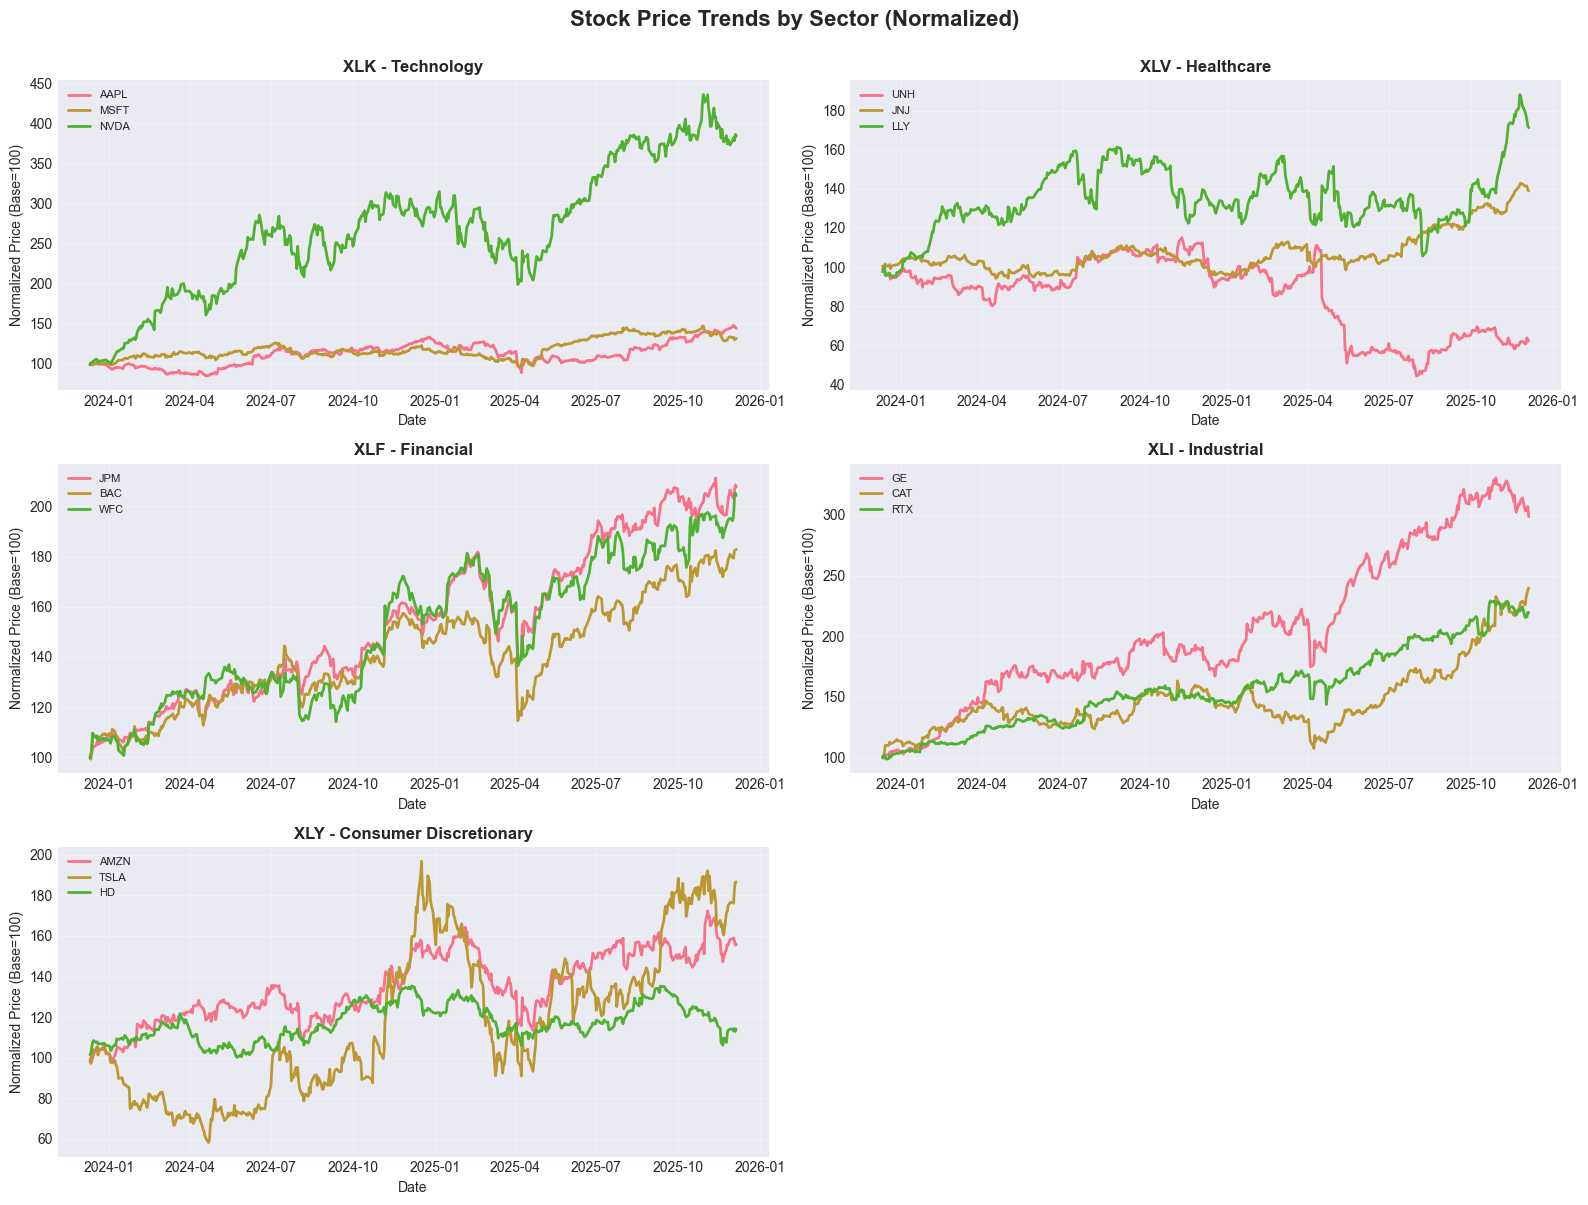

In [ ]:
# Create subplots for each sector
sectors = sector_df['Sector_Code'].unique()
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, sector_code in enumerate(sectors):
    sector_name = sector_df[sector_df['Sector_Code'] == sector_code]['Sector'].iloc[0]
    sector_stocks = [s for s in analysis_stocks if s in sector_df[sector_df['Sector_Code'] == sector_code]['Symbol'].values]
    
    ax = axes[idx]
    
    # Plot normalized prices (starting at 100)
    for stock in sector_stocks:
        if stock in cumulative_returns.columns:
            normalized_price = (1 + cumulative_returns[stock]) * 100
            if USE_ALL_STOCKS:
                # Don't show legend for all stocks (too crowded)
                ax.plot(normalized_price.index, normalized_price.values, linewidth=1, alpha=0.6)
            else:
                ax.plot(normalized_price.index, normalized_price.values, label=stock, linewidth=2)
    
    ax.set_title(f'{sector_code} - {sector_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Normalized Price (Base=100)', fontsize=10)
    if not USE_ALL_STOCKS:
        ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Hide extra subplot if odd number of sectors
if len(sectors) < len(axes):
    axes[-1].axis('off')

plt.suptitle('Stock Price Trends by Sector (Normalized)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 9. Correlation Analysis

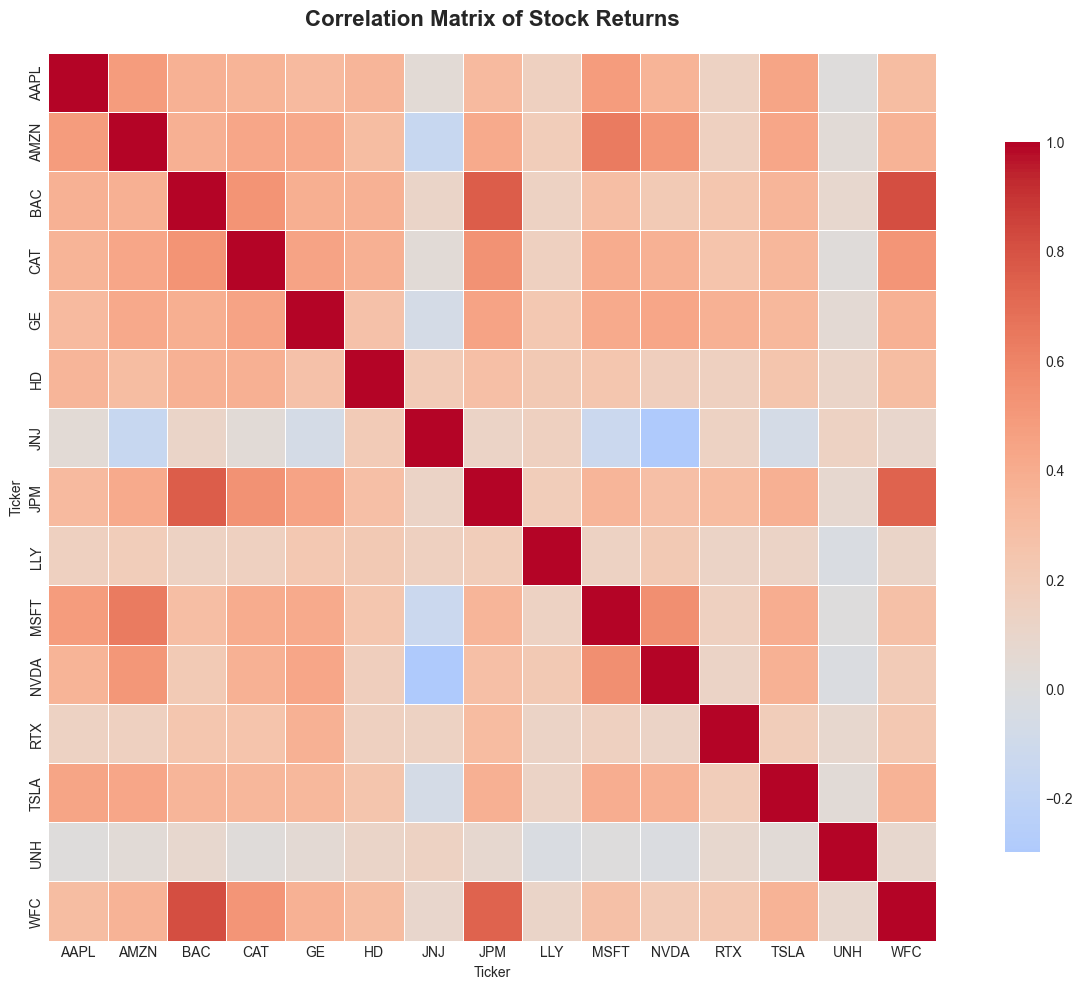


Highest Correlations (excluding self):
Ticker  Ticker
BAC     WFC       0.813878
WFC     BAC       0.813878
BAC     JPM       0.759325
JPM     BAC       0.759325
WFC     JPM       0.740909
JPM     WFC       0.740909
MSFT    AMZN      0.634225
AMZN    MSFT      0.634225
MSFT    NVDA      0.552130
NVDA    MSFT      0.552130
dtype: float64


In [15]:
# Calculate correlation matrix of returns
correlation_matrix = returns.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Stock Returns', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nHighest Correlations (excluding self):")
# Get top correlations
corr_pairs = correlation_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs < 1.0]  # Exclude self-correlation
print(corr_pairs.sort_values(ascending=False).head(10))

## 10. Volatility Analysis

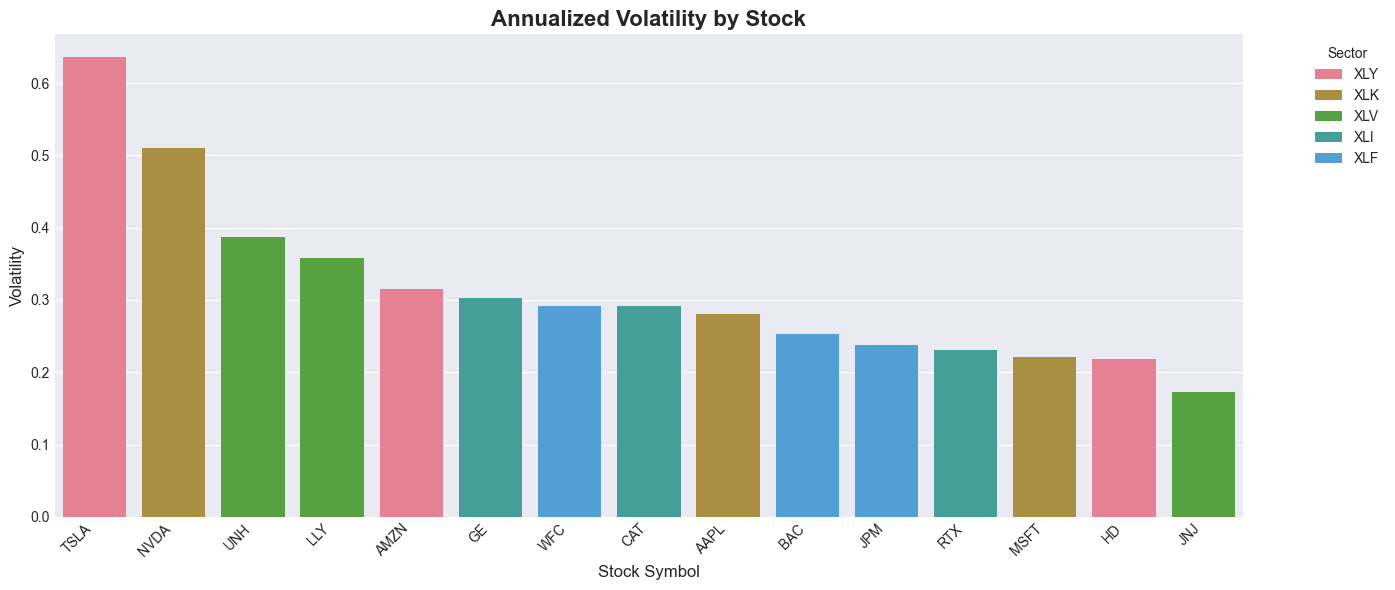


Top 10 Most Volatile Stocks:
   Symbol  Volatility                  Sector Sector_Code
12   TSLA    0.635450  Consumer Discretionary         XLY
10   NVDA    0.510561              Technology         XLK
13    UNH    0.386937              Healthcare         XLV
8     LLY    0.357872              Healthcare         XLV
1    AMZN    0.314547  Consumer Discretionary         XLY
4      GE    0.302956              Industrial         XLI
14    WFC    0.292186               Financial         XLF
3     CAT    0.291223              Industrial         XLI
0    AAPL    0.280881              Technology         XLK
2     BAC    0.253095               Financial         XLF

Average Volatility by Sector:
Sector_Code
XLY    0.389564
XLK    0.337720
XLV    0.305985
XLI    0.274898
XLF    0.261083
Name: Volatility, dtype: float64


In [16]:
# Calculate annualized volatility
volatility = returns.std() * np.sqrt(252)  # 252 trading days

# Create dataframe with volatility
volatility_df = pd.DataFrame({
    'Symbol': volatility.index,
    'Volatility': volatility.values
})

# Add sector information
volatility_df = volatility_df.merge(sector_df[['Symbol', 'Sector', 'Sector_Code']], on='Symbol', how='left')
volatility_df = volatility_df.sort_values('Volatility', ascending=False)

# Plot volatility by sector
plt.figure(figsize=(14, 6))
sns.barplot(data=volatility_df, x='Symbol', y='Volatility', hue='Sector_Code', dodge=False)
plt.title('Annualized Volatility by Stock', fontsize=16, fontweight='bold')
plt.xlabel('Stock Symbol', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Volatile Stocks:")
print(volatility_df.head(10))

print("\nAverage Volatility by Sector:")
print(volatility_df.groupby('Sector_Code')['Volatility'].mean().sort_values(ascending=False))

## 11. Risk-Return Analysis

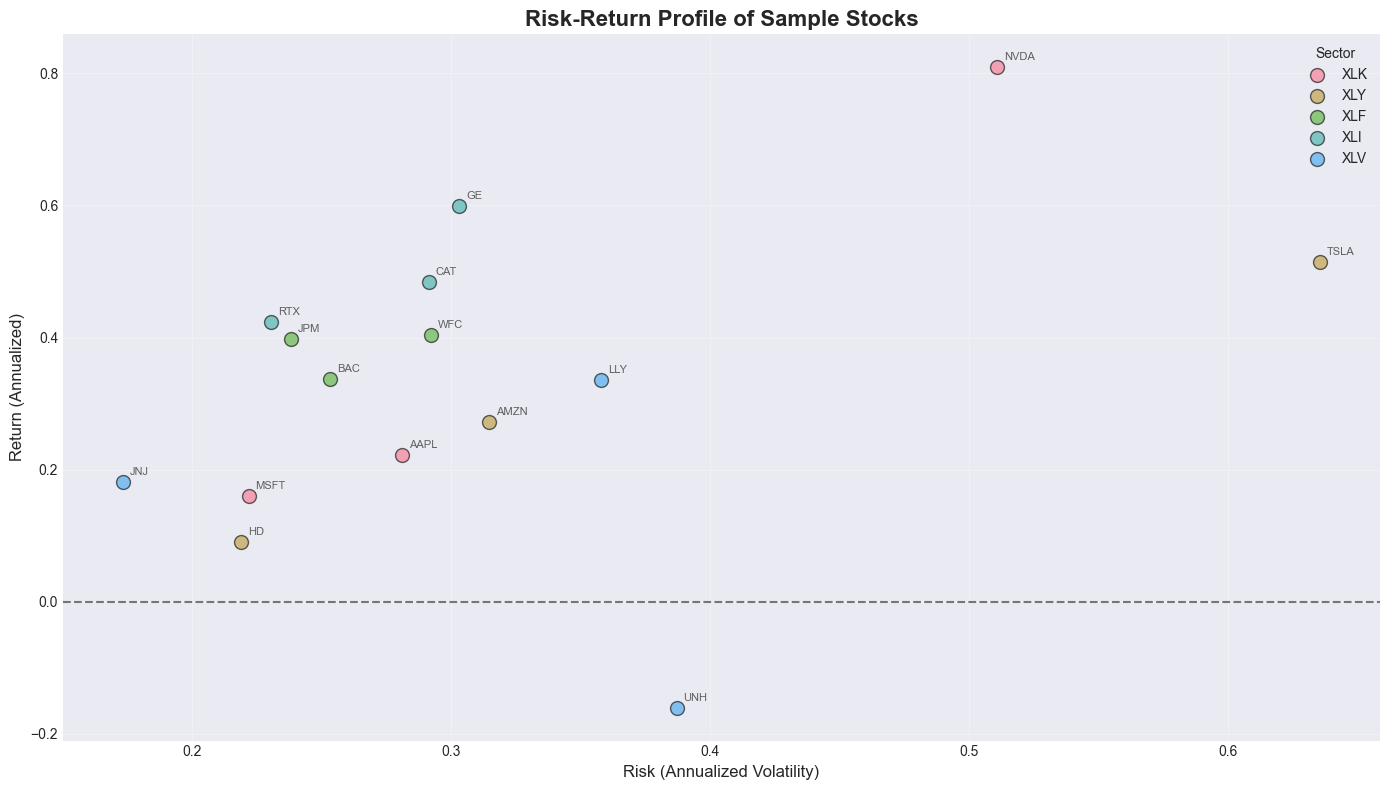


Risk-Return Summary:
   Symbol    Return      Risk                  Sector Sector_Code
10   NVDA  0.810295  0.510561              Technology         XLK
4      GE  0.598812  0.302956              Industrial         XLI
12   TSLA  0.513891  0.635450  Consumer Discretionary         XLY
3     CAT  0.483941  0.291223              Industrial         XLI
11    RTX  0.423621  0.230515              Industrial         XLI
14    WFC  0.403576  0.292186               Financial         XLF
7     JPM  0.397828  0.237967               Financial         XLF
2     BAC  0.337024  0.253095               Financial         XLF
8     LLY  0.336219  0.357872              Healthcare         XLV
1    AMZN  0.272892  0.314547  Consumer Discretionary         XLY
0    AAPL  0.222456  0.280881              Technology         XLK
6     JNJ  0.181472  0.173147              Healthcare         XLV
9    MSFT  0.160947  0.221718              Technology         XLK
5      HD  0.090274  0.218694  Consumer Discretionary 

In [17]:
# Calculate annualized returns
annual_returns = returns.mean() * 252

# Create risk-return dataframe
risk_return_df = pd.DataFrame({
    'Symbol': annual_returns.index,
    'Return': annual_returns.values,
    'Risk': volatility.values
})

# Add sector information
risk_return_df = risk_return_df.merge(sector_df[['Symbol', 'Sector', 'Sector_Code']], on='Symbol', how='left')

# Plot risk-return scatter
plt.figure(figsize=(14, 8))
for sector_code in risk_return_df['Sector_Code'].unique():
    sector_data = risk_return_df[risk_return_df['Sector_Code'] == sector_code]
    plt.scatter(sector_data['Risk'], sector_data['Return'], 
               label=sector_code, s=100, alpha=0.6, edgecolors='black', linewidth=1)
    
    # Add labels for each point
    for idx, row in sector_data.iterrows():
        plt.annotate(row['Symbol'], (row['Risk'], row['Return']), 
                    fontsize=8, alpha=0.7, xytext=(5, 5), textcoords='offset points')

plt.title('Risk-Return Profile of Sample Stocks', fontsize=16, fontweight='bold')
plt.xlabel('Risk (Annualized Volatility)', fontsize=12)
plt.ylabel('Return (Annualized)', fontsize=12)
plt.legend(title='Sector', fontsize=10)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("\nRisk-Return Summary:")
print(risk_return_df.sort_values('Return', ascending=False))

## 12. Performance Metrics Summary

In [18]:
# Calculate Sharpe Ratio (assuming risk-free rate = 0.04 or 4%)
risk_free_rate = 0.04
sharpe_ratio = (annual_returns - risk_free_rate) / volatility

# Create summary dataframe
performance_summary = pd.DataFrame({
    'Symbol': annual_returns.index,
    'Annual_Return': annual_returns.values,
    'Volatility': volatility.values,
    'Sharpe_Ratio': sharpe_ratio.values,
    'Total_Return': cumulative_returns.iloc[-1].values
})

# Add sector information
performance_summary = performance_summary.merge(sector_df[['Symbol', 'Sector', 'Sector_Code']], 
                                                on='Symbol', how='left')

# Sort by Sharpe Ratio
performance_summary = performance_summary.sort_values('Sharpe_Ratio', ascending=False)

print("\nPerformance Summary (Top 10 by Sharpe Ratio):")
print(performance_summary.head(10))

print("\n\nPerformance by Sector:")
sector_performance = performance_summary.groupby('Sector_Code').agg({
    'Annual_Return': 'mean',
    'Volatility': 'mean',
    'Sharpe_Ratio': 'mean',
    'Total_Return': 'mean'
}).round(4)
print(sector_performance.sort_values('Sharpe_Ratio', ascending=False))


Performance Summary (Top 10 by Sharpe Ratio):
   Symbol  Annual_Return  Volatility  Sharpe_Ratio  Total_Return  \
4      GE       0.598812    0.302956      1.844530      1.985152   
11    RTX       0.423621    0.230515      1.664194      1.193584   
3     CAT       0.483941    0.291223      1.524402      1.397298   
10   NVDA       0.810295    0.510561      1.508724      2.841865   
7     JPM       0.397828    0.237967      1.503691      1.077916   
14    WFC       0.403576    0.292186      1.244332      1.043555   
2     BAC       0.337024    0.253095      1.173567      0.828301   
8     LLY       0.336219    0.357872      0.827725      0.713049   
6     JNJ       0.181472    0.173147      0.817065      0.390363   
12   TSLA       0.513891    0.635450      0.745756      0.865978   

                    Sector Sector_Code  
4               Industrial         XLI  
11              Industrial         XLI  
3               Industrial         XLI  
10              Technology         XLK  

## 13. Next Steps for Analysis

Based on this exploratory analysis, here are potential next steps:

1. **Fetch Fundamental Data**: Download company financials (revenue, earnings, margins) using yfinance
2. **Feature Engineering**: Create additional features like moving averages, RSI, momentum indicators
3. **Correlation with Fundamentals**: Analyze relationship between stock returns and financial metrics
4. **Clustering Analysis**: Use K-means or DBSCAN to group similar stocks
5. **Dimensionality Reduction**: Apply PCA to reduce feature space
6. **Predictive Modeling**: Build regression models to predict returns based on fundamentals
7. **Sector Comparison**: Deep dive into sector-specific patterns and trends

## 14. Save Results

In [19]:
# Save performance summary
performance_summary.to_csv('stock_performance_summary.csv', index=False)
print("Performance summary saved to 'stock_performance_summary.csv'")

# Save sector performance
sector_performance.to_csv('sector_performance_summary.csv')
print("Sector performance saved to 'sector_performance_summary.csv'")

print("\nAnalysis complete!")

Performance summary saved to 'stock_performance_summary.csv'
Sector performance saved to 'sector_performance_summary.csv'

Analysis complete!
